# Synthetic experiment
This notebook reproduces the *synthetic experiments* described in Section 5 of the paper titled "On the convergence of ADAM and beyond" (Reddi, Kale and Kumar 2018).

## Imports

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

## Optimizer

In [2]:
class Adam:

    def __init__(self, amsgrad=False, beta1=0.9, beta2=0.99, F=None):
        self.amsgrad = amsgrad
        self.beta1 = beta1
        self.beta2 = beta2
        self.F = F
        self.m = 0
        self.v = 0
        self.beta1_t = 1
        self.beta2_t = 1

    def update(self, x, grad, lr):
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        v = self.beta2 * self.v + (1 - self.beta2) * grad**2

        if not self.amsgrad:
            self.v = v
        else:
            self.v = max(self.v, v)

        m_hat = self.m / (1 - self.beta1)
        v_hat = self.v / (1 - self.beta2)
        x_updated = x - lr * m_hat / (math.sqrt(v_hat) + 1e-8)
        
        if self.F is None:
            return x_updated
        else:
            return np.clip(x_updated, self.F[0], self.F[1])


## Experiment

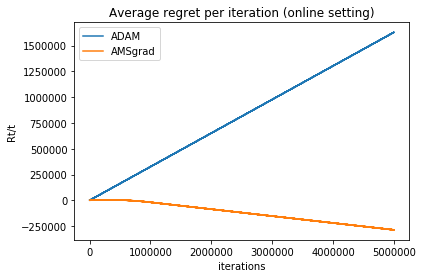

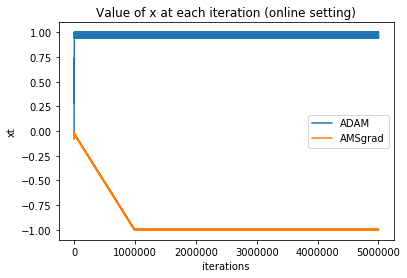

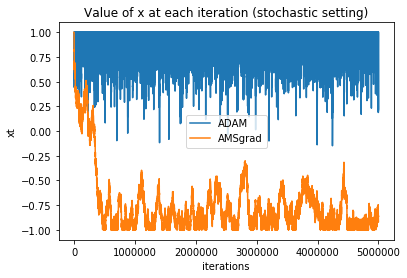

In [3]:
T = 5000000
F = (-1, 1)

iterations = np.arange(1, T + 1, 1)
adam_o, amsg_o = Adam(F=F), Adam(amsgrad=True, F=F)
adam_s, amsg_s = Adam(F=F), Adam(amsgrad=True, F=F)

xs_adam_o, xs_amsg_o = [], []
xs_adam_s, xs_amsg_s = [], []
regrets_adam, regrets_amsg = [], []

x_adam_o, x_amsg_o = 0, 0
x_adam_s, x_amsg_s = 1, 1
loss_adam, loss_amsg, loss_opti = 0, 0, 0

for t in iterations:
    lr_t = 0.01
    
    # Gradients
    grad_o = (1010 if t % 101 == 1 else -10)
    grad_s = (1010 if np.random.random() < 0.01 else -10)

    # Update the xs
    x_adam_o = adam_o.update(x_adam_o, grad_o, lr_t)
    x_amsg_o = amsg_o.update(x_amsg_o, grad_o, lr_t)
    x_adam_s = adam_s.update(x_adam_s, grad_s, lr_t)
    x_amsg_s = amsg_s.update(x_amsg_s, grad_s, lr_t)

    xs_adam_o.append(x_adam_o)
    xs_amsg_o.append(x_amsg_o)
    xs_adam_s.append(x_adam_s)
    xs_amsg_s.append(x_amsg_s)

    # Losses
    loss_adam += grad_o * x_adam_o
    loss_amsg += grad_o * x_amsg_o
    loss_opti += grad_o * -1

    regrets_adam.append(loss_adam - loss_opti / t)
    regrets_amsg.append(loss_amsg - loss_opti / t)

plt.title('Average regret per iteration (online setting)')
plt.xlabel('iterations')
plt.ylabel('Rt/t')
plt.plot(iterations, regrets_adam, label='ADAM')
plt.plot(iterations, regrets_amsg, label='AMSgrad')
plt.legend()
plt.show()

plt.title('Value of x at each iteration (online setting)')
plt.xlabel('iterations')
plt.ylabel('xt')
plt.plot(iterations, xs_adam_o, label='ADAM')
plt.plot(iterations, xs_amsg_o, label='AMSgrad')
plt.legend()
plt.show()

plt.title('Value of x at each iteration (stochastic setting)')
plt.xlabel('iterations')
plt.ylabel('xt')
plt.plot(iterations, xs_adam_s, label='ADAM')
plt.plot(iterations, xs_amsg_s, label='AMSgrad')
plt.legend()
plt.show()
